# How I Used Reinforcement Learning to Beat the Slots in Pokemon
By Daniel Saunders

<img src="celadon.png" alt="Celadon game corner" width="500"/>

[Reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning) is providing a huge boost to many applications, in particular in e-commerce for exploring and anticipating customer behaviour. One popular way to model these problems is as a [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit), but I have always thought the term was an unnecessarily difficult one - considering it's supposed to be a helpful metaphor. First of all "one-armed bandit" is 100-year-old slang, and second, the image of a slot machine with multiple arms to pull, each with different odds, is weird:

<img src="multi-armed-slot.png" alt="Slot machine with multiple arms" width="500"/>

Modern video slot machines no doubt have different buttons to press, supposedly giving different odds, but a better metaphor would be multiple machines in a casino, like the ones being explored by this crazy octopus:

![Crazy octopus illustration](octopus.jpg)

But that illustration (which has been in every MAB talk I've ever seen) confuses the issue, too, because the octopus has multiple arms! (Is this a bandit octopus? Then where is his little robber mask?) 

Nevertheless, it's intuitive to think of some slot machines in a casino as being "loose" and some being "tight". When I walked into the Celadon City Game Corner, playing the 2004 Gameboy Advance game Pokémon FireRed for the first time, and saw rows of slot machines all with different odds, I knew I had found the ideal "real-life" version of this metaphor - and a practical application of reinforcement learning. 

<img src="slots.png" alt="slots" width="500"/>

And I mean practical! How else am I going to win 4000 coins to buy the Ice Beam or Flame Thrower abilities, which I'll need to fight the Elite Four??

I built a reinforcement learning agent, using [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling), to tell me which machine to try next, and, eventually, which to play the hell out of. I call him **MACHAMP: Multi-Armed Coin Holdings Amplifier Made for Pokemon**

<img src="machamp.png" alt="Machamp" width="300"/>

In [1]:
# Import modules and set up plotting defaults

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from multi_armed_bandit.bandits import BernoulliBandit
from multi_armed_bandit.solvers import Solver, EpsilonGreedy, UCB1, BayesianUCB, ThompsonSampling

from machamp import prob_str, plot_beta, plot_betas, plot_credible_intervals, topslots, ThompsonSamplingCGC

matplotlib.rcParams.update({'font.size': 14, 'figure.figsize':(8,5), 'legend.edgecolor':'k'})


## How Thompson sampling works

Given a set of possible actions ("arms" of a multi-armed bandit - in this case different machines to try), Thompson sampling optimally trades off exploration vs exploitation to find the best action, by trying the promising actions more often (and so getting a more detailed estimate of their parameters) while still randomly sampling the others from time to time (in case it turns out one of them is the best after all) The simplest version version of the one-armed bandit problem involves [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial), where there are only two possible outcomes, reward or no reward, and we are trying to determine which action has the highest probability of reward. 

As a demonstration of how it works, I will imagine that we had 4 slot machines, with a 20%, 30%, 50% and 45% chance of payout. Then I'll simulate how it finds that slot 3 is the best one. Here and in the rest of the notebook, I started from [code written by Lilian Weng](https://github.com/lilianweng/multi-armed-bandit) for her [excellent tutorial](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html) (everything in the "multi_armed_bandit" package). 

In [2]:
# Set up the bandit simulator and Thompson sampling solver
np.random.seed(0)

num_slots = 4
probas = [0.2, 0.3, 0.5, 0.45]
b = BernoulliBandit(num_slots, probas)

solver = ThompsonSampling(b)

At the start, we don't know anything about the probabilities of the machines, and assume that all values for their true reward probability are equally possible, from 0% to 100% (this might not be the best possible prior as I discuss below)

Text(0.5, 1.0, 'Posterior probabilities before any pulls')

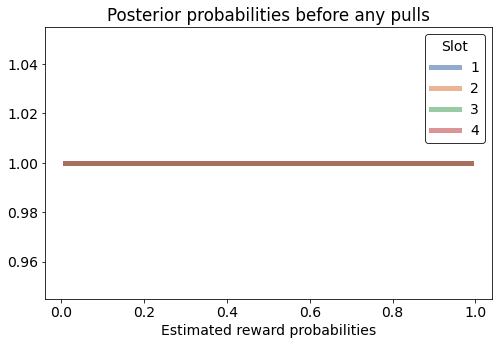

In [3]:
# Plot posterior probabilities just after initialization
sns.set_palette("deep")
for a,b in zip(solver._as, solver._bs):
    plot_beta(a,b)
_ = plt.legend(np.arange(len(solver._as))+1, title="Slot", fontsize=14)
plt.title("Posterior probabilities before any pulls")

In [4]:
print("Estimated probabilities before any pulls: \n{}".format(prob_str(solver.estimated_probas)))

Estimated probabilities before any pulls: 
50.0% 50.0% 50.0% 50.0%


One step of the solver involves randomly sampling from the posterior distributions of all the machines, and trying the best one, then updating these distributions based whether there was a reward.

In [5]:
print("The solver recommends you try machine {}".format(solver.run_one_step()+1))

The solver recommends you try machine 4


In [6]:
print("Estimated probabilities after 1 pull: \n{}".format(prob_str(solver.estimated_probas)))

Estimated probabilities after 1 pull: 
50.0% 50.0% 50.0% 66.7%


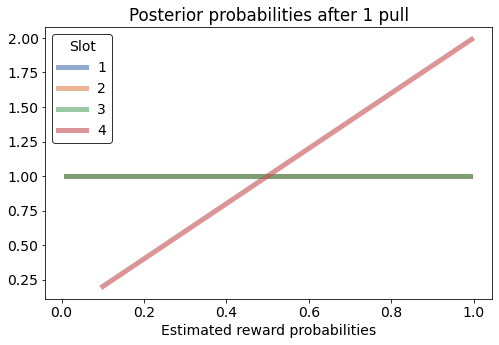

In [7]:
# Plot posterior probabilities after 1 pull
for a,b in zip(solver._as, solver._bs):
    plot_beta(a,b)
plt.legend(np.arange(len(solver._as))+1, title="Slot", fontsize=14)
_ = plt.title("Posterior probabilities after 1 pull")

We can see from the graph of the estimated probabilities that one success for machine 1 has made us more optimistic about that machine - we now think that higher guesses for the reward rate are more likely.

After running it for 100 simulated pulls of the four machines, we can see that it's honed in on better estimates of the probabilities.

In [8]:
# Run the solver for 100 simulated multi-armed bandit pulls, printing estimates at each step
for i in range(100):
    which_machine = solver.run_one_step()
    print("Tried machine {}. Probabilities after update {}".format(which_machine+1, prob_str(solver.estimated_probas)))

Tried machine 1. Probabilities after update 33.3% 50.0% 50.0% 66.7%
Tried machine 1. Probabilities after update 25.0% 50.0% 50.0% 66.7%
Tried machine 4. Probabilities after update 25.0% 50.0% 50.0% 75.0%
Tried machine 3. Probabilities after update 25.0% 50.0% 66.7% 75.0%
Tried machine 3. Probabilities after update 25.0% 50.0% 50.0% 75.0%
Tried machine 2. Probabilities after update 25.0% 33.3% 50.0% 75.0%
Tried machine 3. Probabilities after update 25.0% 33.3% 40.0% 75.0%
Tried machine 4. Probabilities after update 25.0% 33.3% 40.0% 60.0%
Tried machine 4. Probabilities after update 25.0% 33.3% 40.0% 50.0%
Tried machine 4. Probabilities after update 25.0% 33.3% 40.0% 42.9%
Tried machine 3. Probabilities after update 25.0% 33.3% 50.0% 42.9%
Tried machine 3. Probabilities after update 25.0% 33.3% 57.1% 42.9%
Tried machine 2. Probabilities after update 25.0% 50.0% 57.1% 42.9%
Tried machine 3. Probabilities after update 25.0% 50.0% 62.5% 42.9%
Tried machine 3. Probabilities after update 25.0

Estimated probabilities after 100 pulls: 
27.3% 35.3% 52.7% 46.2%
True probabilities: 
20.0% 30.0% 50.0% 45.0%


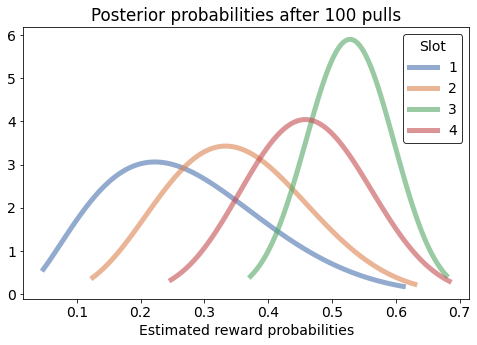

In [9]:
# Plot and list posterior probabilities after 100 pulls
for a,b in zip(solver._as, solver._bs):
    plot_beta(a,b)
_ = plt.legend(np.arange(len(solver._as))+1, title="Slot", fontsize=14)
plt.title("Posterior probabilities after 100 pulls")

print("Estimated probabilities after 100 pulls: \n{}".format(prob_str(solver.estimated_probas)))
print("True probabilities: \n{}".format(prob_str(probas)))

And after 10000 trials we are even more confident that 3 has a high probability of reward, because we sampled 3 much more than the others. We also sampled 4 a lot just to be sure, but 1 and 2 we learned quickly are much worse and so sampled less often - we got much less precise estimates of their reward probabilities, but we don't care. 

We can use this same exact logic to make the most possible money at the Celadon slots!

Estimated probabilities after 10000 pulls: 
14.3% 30.8% 49.4% 45.9%
True probabilities: 
20.0% 30.0% 50.0% 45.0%


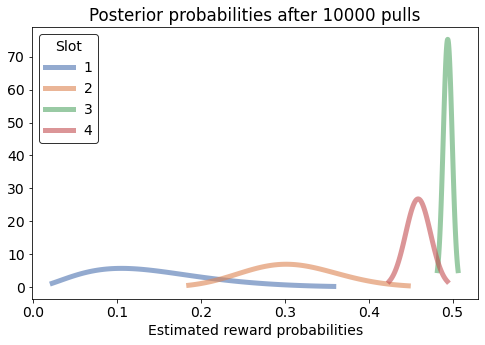

In [10]:
# Run solver for 10000 simulated pulls 
for i in range(10000):
    which_machine = solver.run_one_step()
    
# List and plot posterior probabilities
for a,b in zip(solver._as, solver._bs):
    plot_beta(a,b)
_ = plt.legend(np.arange(len(solver._as))+1, title="Slot", fontsize=14)
plt.title("Posterior probabilities after 10000 pulls")

print("Estimated probabilities after 10000 pulls: \n{}".format(prob_str(solver.estimated_probas)))
print("True probabilities: \n{}".format(prob_str(probas)))

## Understanding the game and simplifying the problem

<img src="celadon-numbered.png?1" alt="Numbered Celadon machines" width="500"/>

There are 19 playable slot machines in the Celadon game corner, which you can play using coins that you purchase at the counter (or find in the stale-beer-smelling carpet). They pay off in coins that can be used to buy TMs (Pokemon abilities) and Pokemon that are unavailable anywhere else. Three wheels spin, and you press a button to stop them, with the goal to line up three of the same picture, or at least a combination that starts with a cherry.

<img src="payouts.png" alt="Payouts" width="300"/>

How did I know the machines had different odds? Because a game character told me so.

<img src="different-odds.png" alt="Different odds" width="300"/>

Before resorting to something as ridiculously complicated as a Thompson sampling MAB solver, I looked online for other advice for beating the casino. Unlike other videogames the information was sparse and sometimes contradictory.
* The two above the old man are best
* Slot 1 is the best
* The one above the woman on the far left is the best
* The odds reset every time you win
* The odds reset every time you enter the casino
* You can enter super-lucky mode where you keep winning every 1-2 rolls
* The game decides whether you can win the jackpot before you press the last slot, so there's no real skill aspect
* "Play each machine 4 times, and if it hits 2 or more, then stick with that one, because it's probably hot"

So starting from that, and not believing all of them, I made some simplifying assumptions:
1. Each machine has a fixed probability for each outcome
1. The probabilities are independent of sequence or time
1. As long as I stay in the room the probabilities won't reset
1. The probability of winning anything on a machine correlates to the probability of winning a jackpot (which is my focus)
1. Stopping at arbitrary times will sample the space uniformly

And simplifying decisions:
1. I will always bet 3 coins, which allows for more ways to win
1. I will record the result of pulls as reward (won anything) or no reward (got nothing), rather than the magnitude of the win, because the losing probability should be a constant as well, and winning even the smallest amount will let me keep playing. Therefore each pull can be represented as a Bernouilli trial.
1. I will not try to time the pulls, but simply smash "stop" three times as quickly as possible without looking
1. I will first systematically try each of the machines 4 times to provide a baseline to kick off the Bayesian exploration.

## Learning from initial exploration
After the initial systematic exploration, where I tried each machine 4 times, I initialized a Thompson-sampling-based solver with the first results. With only four rolls each, it was hard to draw any conclusions about which were good or bad machines, and the credible intervals overlapped greatly, when they weren't identical.

In [11]:
# Read in complete history of machines tried and rewards 
trials = pd.read_csv("machine_reward_history.csv")
trials.loc[:,["Machine","Reward"]].head(10)

,Machine,Reward
0,1,0
1,1,0
2,1,1
3,1,0
4,2,1
5,2,0
6,2,0
7,2,0
8,3,1
9,3,1


In [12]:
# Initialize the Thompson sampling solver and update it with the exploratory history
num_slots = 19
machamp = ThompsonSamplingCGC(num_slots=num_slots)

explore_range = range(0,4*19)
exploratory_trials = list(zip(trials.Machine[explore_range], trials.Reward[explore_range]))

machamp.update_with_list(exploratory_trials)

Text(0.5, 1.0, 'Posterior probabilities after initial exploration')

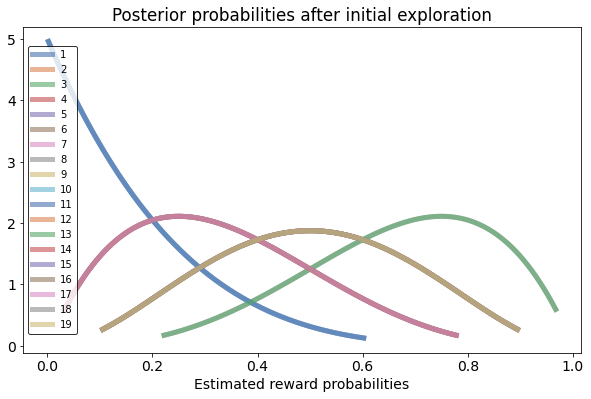

In [13]:
# Plot the posterior probabilities after initial exploration
plot_betas(machamp)
plt.title("Posterior probabilities after initial exploration")

Since the overlaps made it very hard to read the estimates for individual machines, I instead plotted the [credible intervals](https://en.wikipedia.org/wiki/Credible_interval) for each machine: the range of possible values within a certain probability, in this case 80%. It's easy to pick out which machines probably either got 4/4 or 0/4, and how it is fairly improbable that a 0/4 machine is better than a 4/4 machine. Still, a large amount of uncertainty remains, and it's clearly nowhere near enough to pick out the best machine.

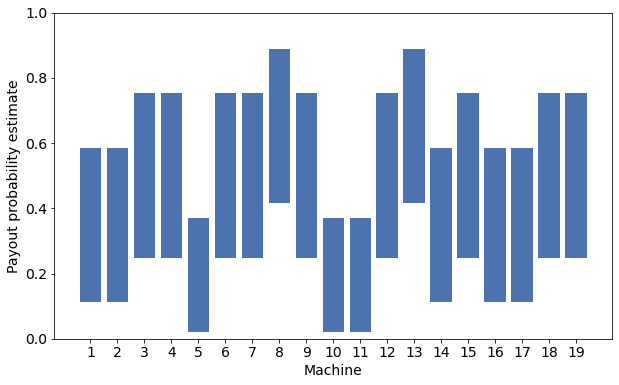

In [14]:
# Plot the 80% credible intervals after initial exploratory pulls
plot_credible_intervals(machamp._as, machamp._bs, 0.2)

## Celadon Nights (MACHAMP-guided play)

Then I started using the solver to recommend which machine to play next. It was very interesting to intuitively feel the balance of exploration and exploitation as the algorithm sent me from one machine to another, with rewards or no rewards. After each trial I updated MACHAMP with the reward I got (0 or 1), and then requested a new recommendation.

In [15]:
# Print stats for the currently most favourable-looking machines
topslots(machamp, topn=5)

Slot 13: 66.7% (3 out of 4)
Slot 8: 66.7% (3 out of 4)
Slot 19: 50.0% (2 out of 4)
Slot 7: 50.0% (2 out of 4)
Slot 3: 50.0% (2 out of 4)


In [16]:
# Get a recommendation for which machine to try next
recommended = machamp.recommend_slot()

I suggest slot 13


In [17]:
# Update the posteriors based on the reward, in this case a success
machamp.update_with_reward(recommended, 1)

In [18]:
# Print updated stats for the top machines
topslots(machamp, topn=5)

Slot 13: 71.4% (4 out of 5)
Slot 8: 66.7% (3 out of 4)
Slot 19: 50.0% (2 out of 4)
Slot 7: 50.0% (2 out of 4)
Slot 3: 50.0% (2 out of 4)


One thing I discovered quickly is that switching machines is costly in terms of time, whereas replaying the same machine is cheap, so I decided to always play a recommended machine 4 times, and then enter all 4 rewards before getting the next recommendation. 

In [19]:
## Actual code used to update machamp with the latest trials
#rewards = [1,0,0,1]
#machamp.update_with_list([(recommended,reward) for reward in rewards])

Even still, the trail I followed would have looked pretty wacky, like those cartoons of Billy walking around the neighbourhood in Family Circus.

<img src="familycircus.jpg" alt="Family circus illustration" width="500"/>

I was certainly fighting my instincts of not sticking with a seemingly winning machine to the exclusion of all others, and instead randomly leaving the "hot" ones to try seemingly unpromising ones that I hadn't thought about in ages. Humans don't think in Thompson-sampling optimal ways!

## Adding a cost to switching machines

After a few hundred pulls I got even more tired of walking from one machine to another, even with the Game Boy Advance emulator cranked up to maximum speed, so I decided to introduce a cost to switching: when all the posterior distributions had been sampled, I would only switch when the "best" machine that round was at least 10% better than the current machine. This definitely reduced the number of switches and let me complete 300 rolls in only about 20 minutes. This switch threshold can be tuned, trading off number of switches for efficiency in converging on the true best machine.

In [20]:
class ThompsonSamplingCGCSwitchCost(ThompsonSamplingCGC):
    def __init__(self, init_a=1, init_b=1, num_slots=5, switch_threshold=0.1):
        super(ThompsonSamplingCGCSwitchCost, self).__init__(init_a, init_b, num_slots)
        self.switch_threshold = switch_threshold
        
    def pick_slot(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        max_index = max(range(self.bandit.n), key=lambda x: samples[x])
        max_proba = samples[max_index]
        if len(self.history) > 0:
            last_index = self.history[-1][0]-1
            last_proba = samples[last_index]
            print("Last slot sampled (%d) proba: %.1f%% Max sampled (%d) proba: %.1f%% Diff: %.1f%%" % (last_index+1, last_proba*100, max_index+1, max_proba*100, 100*(max_proba - last_proba)))
            if (max_proba - last_proba) > self.switch_threshold:
                return max_index
            else:
                return last_index
        else: 
            return max_index

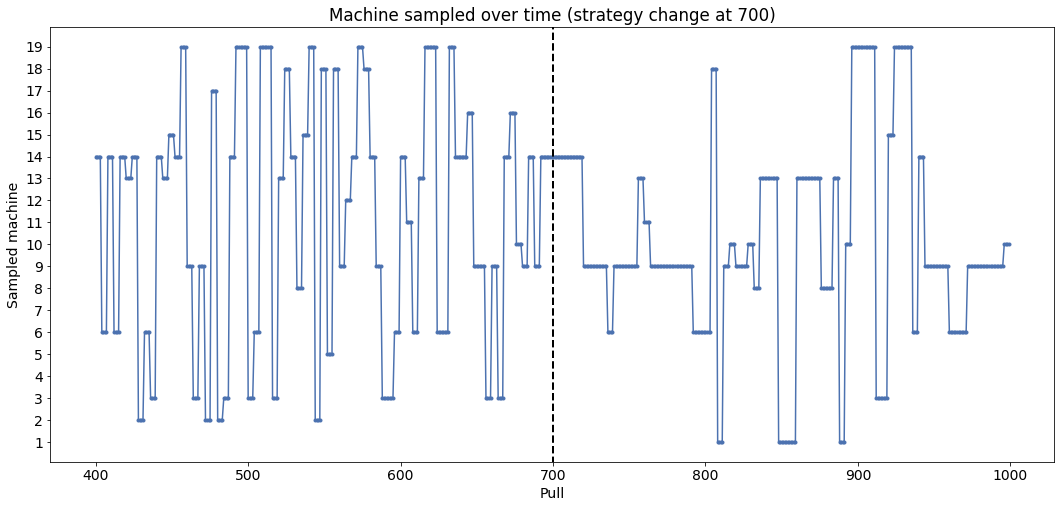

In [21]:
# Plot the machine sampled over time
plt.figure(figsize=(18,8))
plt.plot(trials.iloc[400:1000].Machine,'.-')
plt.xlabel("Pull")
plt.ylabel("Sampled machine")
a = plt.yticks(np.arange(19)+1)
plt.title("Machine sampled over time (strategy change at 700)")
plt.gca().add_line(plt.Line2D([700,700],[0,20],linestyle="--",color="k",linewidth=2))
plt.draw()

## Final results

I stopped after 1000 pulls of the slot machine levers, and took a look at what I had learned. First, there was an imbalance in which machines I had sampled, and it was towards the most promising machines based on successes.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Number of pulls per machine')

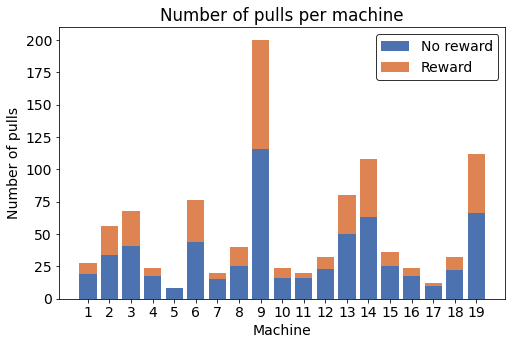

In [22]:
# Plot stacked bars of the successes and failures at each machine
a = trials.iloc[:1000].loc[:,['Machine','Reward']].pivot_table(index='Machine',columns='Reward',aggfunc=len)
plt.bar(np.arange(1,20),a.values[:,0])
plt.bar(np.arange(1,20),a.values[:,1],bottom=a.values[:,0])
plt.legend()
plt.xlabel("Machine")
plt.ylabel("Number of pulls")
plt.legend(["No reward","Reward"])
a = plt.xticks(np.arange(19)+1)
plt.title("Number of pulls per machine")

This was reflected in the final credible intervals, which were in general wider for the machines that seemed to be worse.

Slot 6: 42.3% (32 out of 76)
Slot 9: 42.1% (84 out of 200)
Slot 14: 41.8% (45 out of 108)
Slot 19: 41.2% (46 out of 112)
Slot 3: 40.0% (27 out of 68)


Text(0.5, 1.0, 'Credible intervals for machines after 1000 trials')

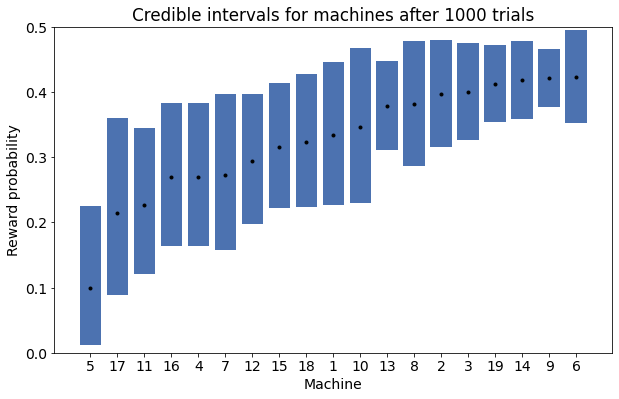

In [23]:
# Plot credible intervals and top machine statistics after all Thompson sampling trials (first 1000)
num_slots = 19
machamp = ThompsonSamplingCGC(num_slots=num_slots)

thompson_range = range(0,1000)
thompson_trials = list(zip(trials.Machine[thompson_range], trials.Reward[thompson_range]))

machamp.update_with_list(thompson_trials)
order = np.argsort(machamp.estimated_probas)

plot_credible_intervals(np.array(machamp._as)[order],np.array(machamp._bs)[order],0.2)
plt.plot(np.arange(len(machamp._as))+1, np.array(machamp.estimated_probas)[order],'k.')
plt.ylabel("Reward probability")
a = plt.xticks(np.arange(19)+1, order+1)
plt.ylim([0,0.5])
topslots(machamp, topn=5)
plt.title("Credible intervals for machines after 1000 trials")

Text(0.5, 1.0, 'Posterior probabilities after 1000 trials')

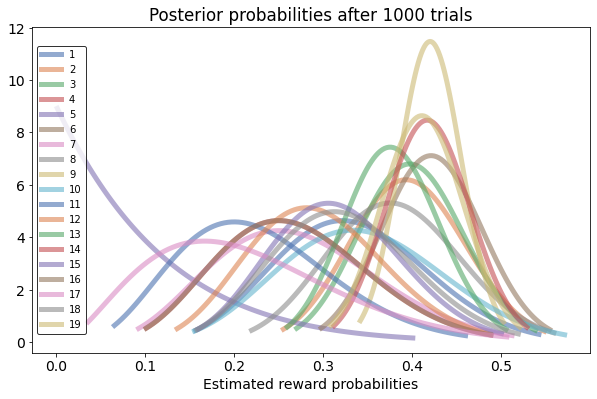

In [24]:
# Plot posterior probabilities after 1000 trials
plot_betas(machamp)
plt.title("Posterior probabilities after 1000 trials")

I couldn't be confident what was the very best, like no one ever was, but I could have an idea of which were among the best, and how they differed from what were probably the worst, e.g. machine 5, that returned exactly 0 rewards in 8 pulls.

Text(0.5, 1.0, 'Posterior probabilities of best, worst, and middlest machines')

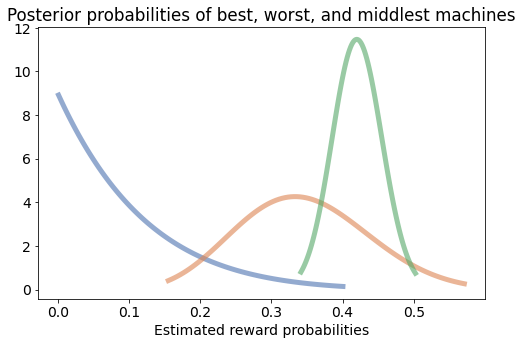

In [33]:
# Plot posterior probabilities of best, worst, and middlest machines after 1000 trials
plot_beta(machamp._as[4], machamp._bs[4])
plot_beta(machamp._as[9], machamp._bs[9])
plot_beta(machamp._as[8], machamp._bs[8])
plt.title("Posterior probabilities of best, worst, and middlest machines")

In [26]:
# Compute stats for machine 5
print("Machine 5: {} rewards out of {}".format(trials.loc[trials.Machine == 5,'Reward'].sum(), 
                                               trials.loc[trials.Machine == 5,'Reward'].count()))

Machine 5: 0 rewards out of 8


## Cashing In

Of course I could have always just spread all 1000 rolls evenly across the 19 machines, 52 rolls each, but this would have led to many more losses as I kept playing machines that were clearly losers, what is called [regret](https://en.wikipedia.org/wiki/Bayesian_regret). Although to save time I didn't track my winnings, even the jackpots, after 1000 rolls playing with **MACHAMP** had amplified my bankroll from 120 to 3977 coins. 

Based on these results, I decided to focus on machine 9, which *was indeed one of the ones above the old man*. It had one of the best estimated reward rates (42.1%), but also importantly, had a narrow credible interval, thanks to all the times I tried it (119): I could be confident it's definitely among the best.

I did another 1000 pulls just on machine 9, both to test this in practice and to make that coin. (Also, it was election day.) Across all 1200 I won 37.7% of the time, which is noticeably lower than the MACHAMP estimate - but just within the 80% credible interval. I think the algorithm is conservatively biased towards 50%, since I used a uniform prior  (all values between 0 and 100% being equally likely). Knowing what I know now, that these machines probably don't pay out more than 40%, I could have started with a different prior that would let me get more accurate estimates with the same number of trials.

I started tracking my winnings with these 1000 trials, and discovered an important strategic point, that you could probably guess from looking at the payout list: only the jackpots matter. All that the other rewards do is keep you in the game. Which they do pretty well at the machine 9 reward rate! The most I ever dropped was 90 coins, so in theory that's all you need in your pocket, once you know what the best machine is. Then the jackpots were what really raised my bankroll. Walk in with 90 coins, walk out with 10,000.

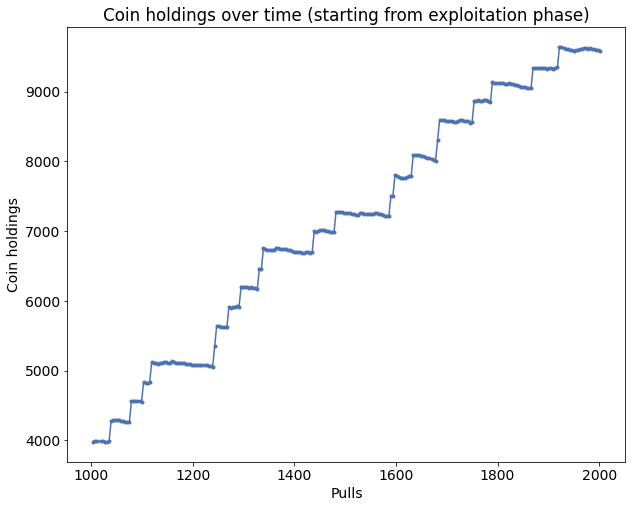

In [27]:
# Plot coin holdings over time
plt.figure(figsize=(10,8))
plt.plot(trials.Bankroll[1000:].dropna().index, trials.Bankroll[1000:].dropna(),'.-')
plt.xlabel('Pulls')
plt.ylabel('Coin holdings')
_ = plt.title("Coin holdings over time (starting from exploitation phase)")

I hit 21 jackpots, for a rate of one in every 48 pulls. I made 5666 coins in 1000 pulls, so machine 9 gave me an expected earning of **5.6 coins per pull**. Using the emulator at high speed, I could probably do at least 1 pull per second (when I'm not entering results in a spreadsheet, let alone switching machines!) So that's about 336 coins, or about **1 jackpot per minute**. I bet that's actually faster than one method recommended online, of saving the emulator state before each pull (also I arbitrarily decided that was too much like cheating!)

In [28]:
print("Actual payout rate of machine 9: %.1f%%" % (100*trials.loc[trials.Machine == 9].Reward.mean()))

Actual payout rate of machine 9: 38.6%


In [29]:
print("Total coins earned in exploitation phase: %d" % (trials.Bankroll.max()-trials.Bankroll.min()))

Total coins earned in exploitation phase: 5666


In [30]:
print("Coins per pull: %.2f" % (5666/1000))

Coins per pull: 5.67


In [31]:
print("Number of jackpots: %d" % np.sum(trials.Jackpot))

Number of jackpots: 21


In [32]:
# Computation of biggest cash drop: when a new maximum is reached, how low do we drop from there?
last_max = -1
last_min = 10000
biggest_drop = 0
for b in trials.Bankroll.dropna():
    if b > last_max:
        if last_max - last_min > biggest_drop:
            biggest_drop = last_max - last_min
        last_max = b
        last_min = 10000
    if b < last_min:
        last_min = b
print("Biggest drop in holdings: %d" % biggest_drop)

Biggest drop in holdings: 90


## Conclusion

Not only was I able to buy everything I needed for the Elite 4, I did it without having to trust sketchy - and sometimes even superstitious - information from internet forums. **MACHAMP** gave me a strong read on which were the best machines in the theoretically most efficient way. A **MACHAMP**-style solver could be used to play any gambling minigame of this type, starting from zero knowledge. Just don't try it on real slot machines - I bet they're a lot sneakier!

Besides the Shadow Balls, Ice Beams, Flame Throwers, and Porygons I earned, by literally pulling the lever myself each time at each machine and seeing how the posterior distributions changed, I got what I was looking for: a gut level understanding of Thompson sampling and Bayesian reinforcement learning. In other words: To catch coins was my real test; to train myself was my cause.